# Predicting Credit Default

Data set consists of total ~30k rows with 26 features (including the customer ID). 

1. EDA & Data Preprocessing
1. Modelling
1. Evaluation & Feature Importance

In [123]:
# Parameters 

data_file_path = 'data case - defaults.xlsx'
random_seed = 42
test_size = 0.2
k_fold = 5 

# Rename column names

features = ["credit", "gender", "education", "single", "age", "delay_S", "delay_Au", "delay_Jy", "delay_J", "delay_M", "delay_A", 
                "bill_S", "bill_Au", "bill_Jy", "bill_J", "bill_M", "bill_A",
                "paid_S", "paid_Au", "paid_Jy", "paid_J", "paid_M", "paid_A",
                "income"]
target_value = ["default"]

column_names = features + target_value



In [124]:
# Libraries

import matplotlib.pyplot as plt
import pandas as pd
import xgboost as xgb
from sklearn.metrics import (classification_report, confusion_matrix, f1_score,
                             precision_score, recall_score, roc_auc_score)
from sklearn.model_selection import GridSearchCV, train_test_split

pd.set_option('display.max_columns', 50)

## EDA & Data Preprocessing

In [139]:
# Load data

data = pd.read_excel(data_file_path, skiprows=[0], names=column_names, index_col=0) 
data.info()
data.describe()

<class 'pandas.core.frame.DataFrame'>
Index: 30019 entries, 1 to 30022
Data columns (total 25 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   credit     30018 non-null  float64
 1   gender     30018 non-null  float64
 2   education  30017 non-null  float64
 3   single     30018 non-null  float64
 4   age        30014 non-null  float64
 5   delay_S    30017 non-null  float64
 6   delay_Au   30018 non-null  float64
 7   delay_Jy   30017 non-null  float64
 8   delay_J    30017 non-null  float64
 9   delay_M    30018 non-null  float64
 10  delay_A    30018 non-null  float64
 11  bill_S     30018 non-null  float64
 12  bill_Au    30017 non-null  float64
 13  bill_Jy    30018 non-null  float64
 14  bill_J     30017 non-null  float64
 15  bill_M     30017 non-null  float64
 16  bill_A     30017 non-null  float64
 17  paid_S     30017 non-null  float64
 18  paid_Au    30018 non-null  float64
 19  paid_Jy    30018 non-null  float64
 20  paid_J     

,credit,gender,education,single,age,delay_S,delay_Au,delay_Jy,delay_J,delay_M,delay_A,bill_S,bill_Au,bill_Jy,bill_J,bill_M,bill_A,paid_S,paid_Au,paid_Jy,paid_J,paid_M,paid_A,income,default
count,30018.000000,30018.000000,30017.000000,30018.000000,30014.000000,30017.000000,30018.000000,30017.000000,30017.000000,30018.000000,30018.000000,30018.000000,30017.000000,3.001800e+04,30017.000000,30017.000000,30017.000000,30017.000000,3.001800e+04,30018.000000,30016.000000,30018.000000,30018.000000,30017.000000,30019.000000
mean,167475.170897,1.604038,1.852917,1.552035,35.478643,-0.016857,-0.134020,-0.166306,-0.220675,-0.266374,-0.291192,51212.724565,49169.925209,4.700189e+04,43255.560982,40305.068461,38865.066596,5661.752274,5.919483e+03,5223.757745,4824.380064,4797.470584,5214.025285,55055.267882,0.221093
std,129734.062813,0.489065,0.790224,0.521938,9.218451,1.123703,1.196989,1.196814,1.169108,1.133053,1.149916,73631.474193,71170.518522,6.934598e+04,64333.083875,60793.731159,59551.469698,16558.905174,2.303419e+04,17601.939507,15662.238724,15273.970377,17772.558051,20951.873002,0.414990
min,10000.000000,1.000000,0.000000,0.000000,21.000000,-2.000000,-2.000000,-2.000000,-2.000000,-2.000000,-2.000000,-165580.000000,-69777.000000,-1.572640e+05,-170000.000000,-81334.000000,-339603.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,-1244.000000,0.000000
25%,50000.000000,1.000000,1.000000,1.000000,28.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,3556.000000,2984.000000,2.663000e+03,2320.000000,1763.000000,1256.000000,1000.000000,8.352500e+02,390.000000,295.750000,251.500000,118.000000,37502.000000,0.000000
50%,140000.000000,2.000000,2.000000,2.000000,34.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,22366.500000,21190.000000,2.008550e+04,19040.000000,18101.000000,17067.000000,2100.000000,2.009000e+03,1800.000000,1500.000000,1500.000000,1500.000000,55183.000000,0.000000
75%,240000.000000,2.000000,2.000000,2.000000,41.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,67081.500000,63995.000000,6.014400e+04,54484.000000,50176.000000,49171.000000,5006.000000,5.000000e+03,4502.750000,4013.000000,4031.000000,4000.000000,72625.000000,0.000000
max,1000000.000000,2.000000,6.000000,3.000000,79.000000,8.000000,8.000000,8.000000,8.000000,8.000000,8.000000,964511.000000,983931.000000,1.664089e+06,891586.000000,927171.000000,961664.000000,873552.000000,1.684259e+06,896040.000000,621000.000000,426529.000000,528666.000000,987133.000000,1.000000


In [126]:
print(f'Number of rows that are missing at least one value:  {data.isna().any(axis=1).sum()}')

Number of rows that are missing at least one value:  18


Observations: 
- 30,022 data points with 25 features
- amount of credit ranges from 10k NT to 1M NT; in average 167k NT
- 60% men
- average age 35 years
- 22% will default next month

On average, a male customer aged 35 years would have a credit limit of 167,000 NT, make monthly payments of approximately 5,000 NT, and would not default next month.

Critical observations:
- default classification is missing or random integer for 3 data points: 5, - ,3 -> Filter for 0|1 
- missing values in some features (blank)
- negative/ very low income in application (sorted: -1244 [1], -456 [0], -558 [0], 12 [0], 20k)  
- more categories in education: 0-6 
- repayment status also includes -2, 0 
- negative bill statements

In [127]:
# Pre-processing & data split

data = data[(data['default'] == 0) | (data['default'] == 1)]

X_train, X_test, y_train, y_test = train_test_split(data.drop(target_value, axis=1), data[target_value], test_size=test_size, random_state=random_seed, shuffle=True)
print('Train: ',X_train.shape, '\nTest: ', X_test.shape)

Train:  (24015, 24) 
Test:  (6004, 24)


Since XGBoost is able to deal with missing data in the features, the pre-processing only includes to choose data points that have a binary classification (0/1)

=> 30019 data points

## Modelling

### XGBoost

XGBoost is an ensemble learning method that combines the predictions of multiple weak learners (typically decision trees) to create a strong predictive model. It builds trees sequentially, with each new tree correcting the errors of the previous ones. XGBoost includes L1 (Lasso regression) and L2 (Ridge regression) regularization terms to control overfitting. Regularization helps prevent the model from fitting the noise in the training data and results in better generalization to unseen data. 

+ faster and more efficient than traditional gradient boosting implementations
+ handles missing data 
+ provides feature importance score 
+ is robust to multicollinearity (high feature correlation) 

### Hypertuning

Using GridSearch to find the optimal hyperparameters leading to the best validation score, here AUC-ROC. 


FP = A person who will pay but predicted as defaulter

FN = A person who default but predicted as payer   <- Minimise, focus on better recall 

if you want to minimize financial losses associated with defaults, you might prioritize precision to reduce false alarms. If capturing as many defaults as possible is critical, you might prioritize recall.
=> AUC-ROC

In [ ]:
# Hyperparameter tuning using GridSearch

param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 4, 5],
    'learning_rate': [0.01, 0.1, 0.2],
}
xgb_model = xgb.XGBClassifier()
grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, scoring='roc_auc', cv=k_fold, verbose=1)
grid_search.fit(X_train, y_train)


In [129]:
best_model = grid_search.best_estimator_
best_params = best_model.get_params()
print("Best Model Parameters:")
print(best_params)

Best Model Parameters:
{'objective': 'binary:logistic', 'use_label_encoder': None, 'base_score': None, 'booster': None, 'callbacks': None, 'colsample_bylevel': None, 'colsample_bynode': None, 'colsample_bytree': None, 'early_stopping_rounds': None, 'enable_categorical': False, 'eval_metric': None, 'feature_types': None, 'gamma': None, 'gpu_id': None, 'grow_policy': None, 'importance_type': None, 'interaction_constraints': None, 'learning_rate': 0.1, 'max_bin': None, 'max_cat_threshold': None, 'max_cat_to_onehot': None, 'max_delta_step': None, 'max_depth': 3, 'max_leaves': None, 'min_child_weight': None, 'missing': nan, 'monotone_constraints': None, 'n_estimators': 100, 'n_jobs': None, 'num_parallel_tree': None, 'predictor': None, 'random_state': None, 'reg_alpha': None, 'reg_lambda': None, 'sampling_method': None, 'scale_pos_weight': None, 'subsample': None, 'tree_method': None, 'validate_parameters': None, 'verbosity': None}


## Evaluation & Feature Importance

Evaluation of the hypertuned XGBoost model on the test data. Focus on AUC-ROC.




In [ ]:
# Evaluation on test data

test_predictions = best_model.predict(X_test)  
test_probabilities = best_model.predict_proba(X_test)[:, 1]  # Probability of positive class (1)

# Calculate AUC-ROC, Recall, Precision, F1-Score
auc_roc = roc_auc_score(y_test, test_probabilities)
recall = recall_score(y_test, test_predictions)
precision = precision_score(y_test, test_predictions)
f1 = f1_score(y_test, test_predictions)

print(f'AUC-ROC: {auc_roc:.4f}')
print(f'Recall: {recall:.4f}')
print(f'Precision: {precision:.4f}')
print(f'F1-Score: {f1:.4f}')

conf_matrix = confusion_matrix(y_test, test_predictions)
print("Confusion Matrix:")
print(conf_matrix)

class_report = classification_report(y_test, test_predictions)
print("\nClassification Report:")
print(class_report)

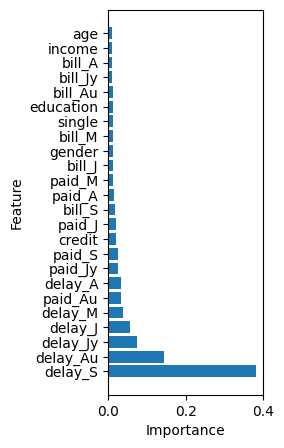

In [138]:
# Feature Importance

feature_importances = best_model.feature_importances_
feature_importance_df = pd.DataFrame({'Feature': X_train.columns, 'Importance': feature_importances})

# Sort the features by importance in descending order
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Plot feature importances
plt.figure(figsize=(2, 5))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'])
plt.xlabel('Importance')
plt.ylabel('Feature')
#plt.title('Feature Importance')
plt.show()